<a href="https://colab.research.google.com/github/GaliMohan/Assignments/blob/main/MS_DS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance pandas matplotlib scikit-learn tensorflow --quiet


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

%matplotlib inline

# -------- CONFIG --------
TICKER = "AAPL"           # change this to any stock
START_DATE = "2015-01-01"
END_DATE = None           # None = up to today
LOOKBACK = 60             # past days used as input
TEST_RATIO = 0.2
EPOCHS = 15               # you can increase
BATCH_SIZE = 32
# ------------------------


In [4]:
print(f"Downloading data for {TICKER}...")
data = yf.download(TICKER, start=START_DATE, end=END_DATE)
data.dropna(inplace=True)
data.head()


/tmp/ipython-input-1195349914.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237551,24.705320,23.798600,24.694235,212818400
2015-01-05,23.554741,24.086801,23.368521,24.006992,257142000
2015-01-06,23.556963,23.816342,23.195604,23.619036,263188400
2015-01-07,23.887278,23.987038,23.654501,23.765347,160423600
2015-01-08,24.805082,24.862723,24.097885,24.215383,237458000


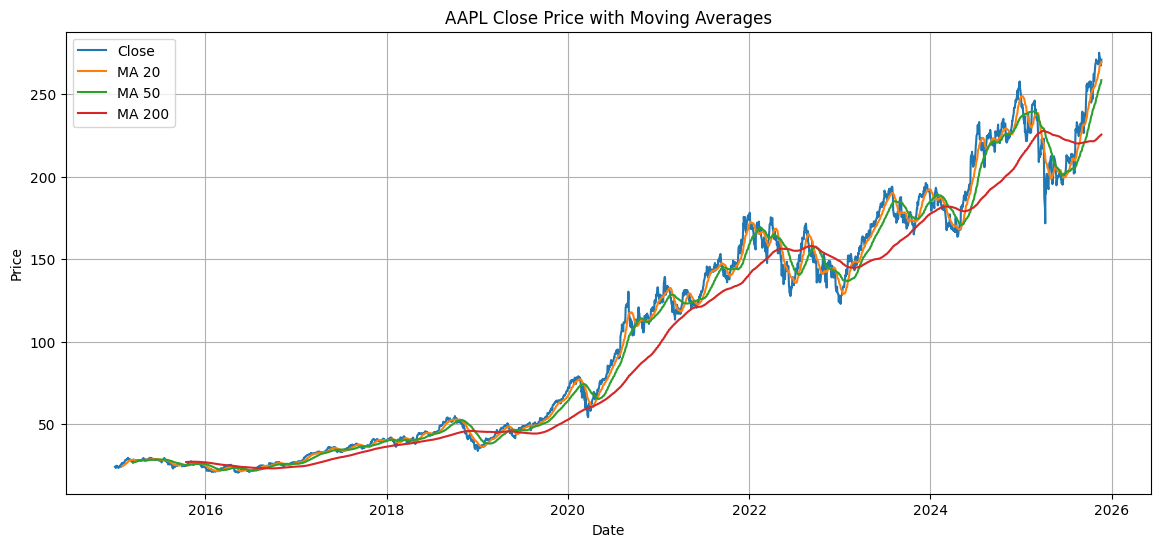

In [5]:
plt.figure(figsize=(14,6))
plt.plot(data.index, data["Close"], label="Close")
plt.plot(data["Close"].rolling(20).mean(), label="MA 20")
plt.plot(data["Close"].rolling(50).mean(), label="MA 50")
plt.plot(data["Close"].rolling(200).mean(), label="MA 200")
plt.title(f"{TICKER} Close Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


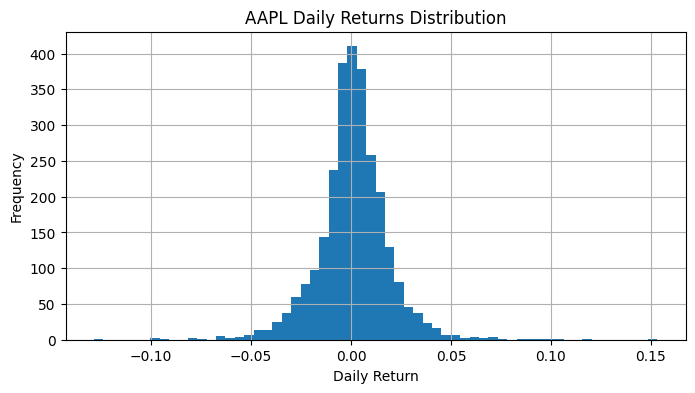

In [6]:
data["Returns"] = data["Close"].pct_change()
plt.figure(figsize=(8,4))
plt.hist(data["Returns"].dropna(), bins=60)
plt.title(f"{TICKER} Daily Returns Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [8]:
import matplotlib as mpl
mpl.rcParams["patch.linewidth"] = 1.0  # reset to a scalar


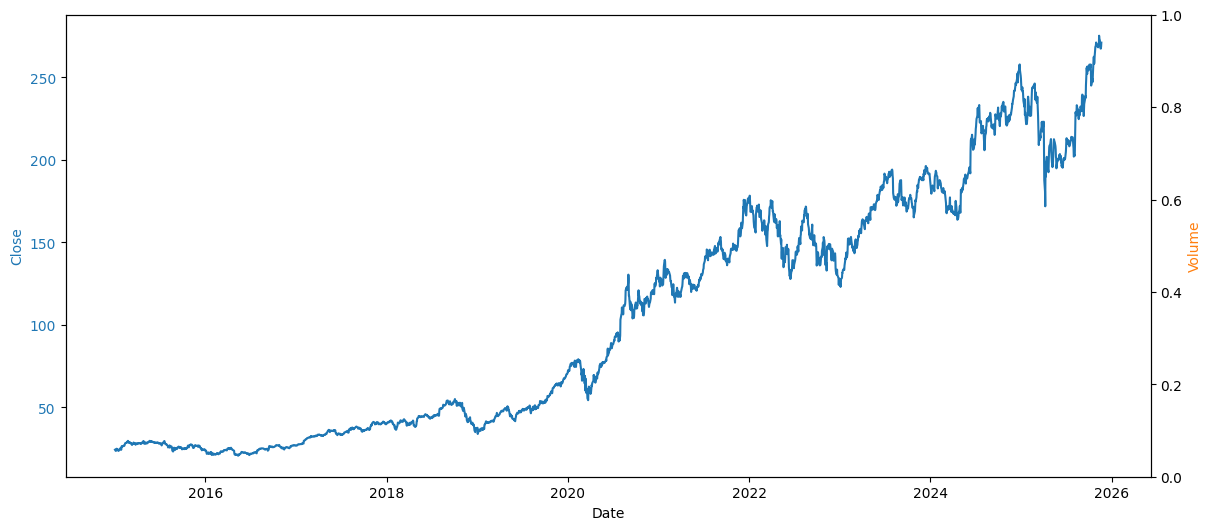

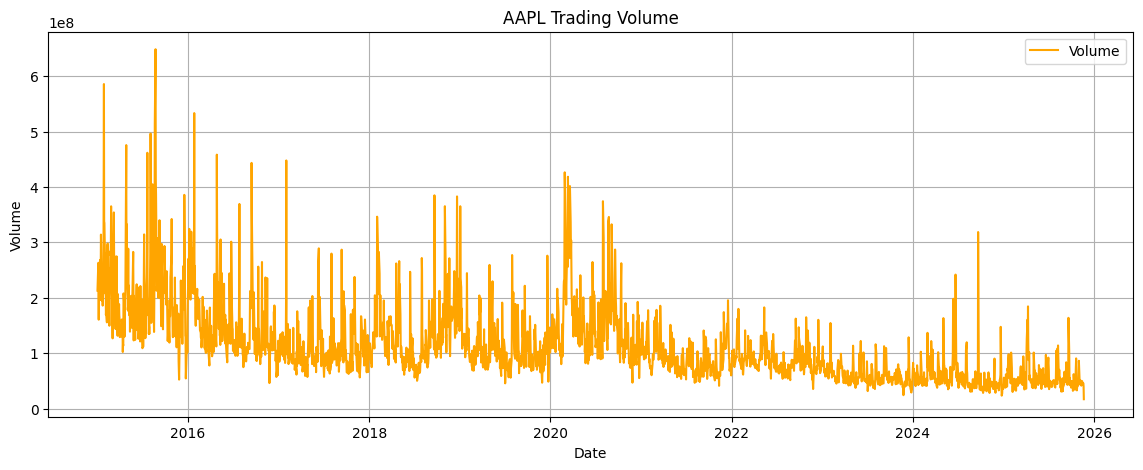

In [19]:
plt.figure(figsize=(14,5))
plt.plot(data["Volume"], label="Volume", color="orange")
plt.title(f"{TICKER} Trading Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/misc.py:454: RuntimeWarning: invalid value encountered in scalar divide
  c0 = np.sum((data - mean) ** 2) / n
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/misc.py:463: RuntimeWarning: divide by zero encountered in scalar divide
  ax.axhline(y=z99 / np.sqrt(n), linestyle="--", color="grey")
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/misc.py:464: RuntimeWarning: divide by zero encountered in scalar divide
  ax.axhline(y=z95 / np.sqrt(n), color="grey")
/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/misc.py:466: RuntimeWarning: divide 

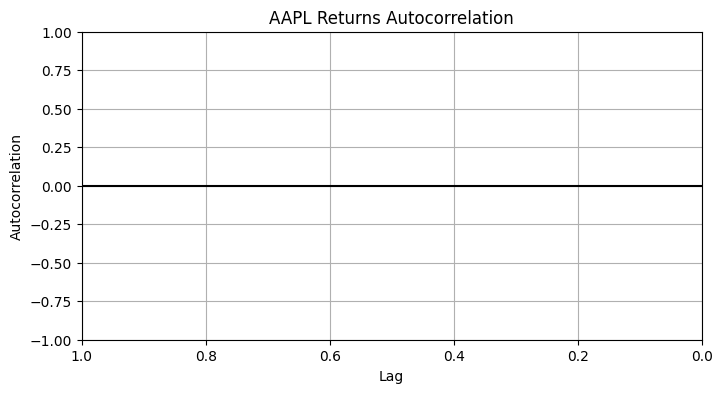

In [20]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(8,4))
autocorrelation_plot(data["Returns"].dropna())
plt.title(f"{TICKER} Returns Autocorrelation")
plt.show()


In [21]:
# Use only Close prices for DL models
close_prices = data[["Close"]].values

# Scale to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_prices)

def create_sequences(series, lookback):
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i - lookback:i, 0])
        y.append(series[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_close, LOOKBACK)
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)

# Train/test split (time-based)
split_index = int(len(X) * (1 - TEST_RATIO))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (2143, 60, 1) X_test: (536, 60, 1)


In [23]:
#To evaluate and inverse square
def evaluate_and_plot(model, name, color=None):
    # Predictions
    train_pred = model.predict(X_train)
    test_pred  = model.predict(X_test)

    # Inverse transform
    train_pred_inv = scaler.inverse_transform(train_pred)
    test_pred_inv  = scaler.inverse_transform(test_pred)
    y_train_inv    = scaler.inverse_transform(y_train.reshape(-1,1))
    y_test_inv     = scaler.inverse_transform(y_test.reshape(-1,1))

    # RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
    test_rmse  = np.sqrt(mean_squared_error(y_test_inv,  test_pred_inv))
    print(f"{name} – Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    # Build aligned dates
    all_dates = data.index[LOOKBACK:]
    train_len = len(y_train)
    train_dates = all_dates[:train_len]
    test_dates  = all_dates[train_len:]

    # Plot
    plt.figure(figsize=(14,6))
    plt.plot(data.index, data["Close"], label="Actual Close", alpha=0.5)
    plt.plot(train_dates, train_pred_inv[:,0], label=f"{name} Train Pred")
    plt.plot(test_dates, test_pred_inv[:,0], label=f"{name} Test Pred")
    plt.title(f"{TICKER} – {name} Predictions vs Actual")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0221 - val_loss: 0.0044
Epoch 2/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 3/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 9.0775e-04 - val_loss: 0.0017
Epoch 4/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 8.0939e-04 - val_loss: 0.0043
Epoch 5/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 8.3013e-04 - val_loss: 0.0028
Epoch 6/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 7.3211e-04 - val_loss: 0.0058
Epoch 7/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 6.3160e-04 - val_loss: 0.0014
Epoch 8/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 7.1684e-04 - val_loss: 0.0027
Epoch 9/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 5.4523e-04 - val_loss: 0.0049
Epoch 10/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 6.1650e-04 - val_loss: 0.0040
Epoch 11/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 5.9716e-04 - val_loss: 0.0015
Epoch 12/15
67/67 ━━━━━━━━

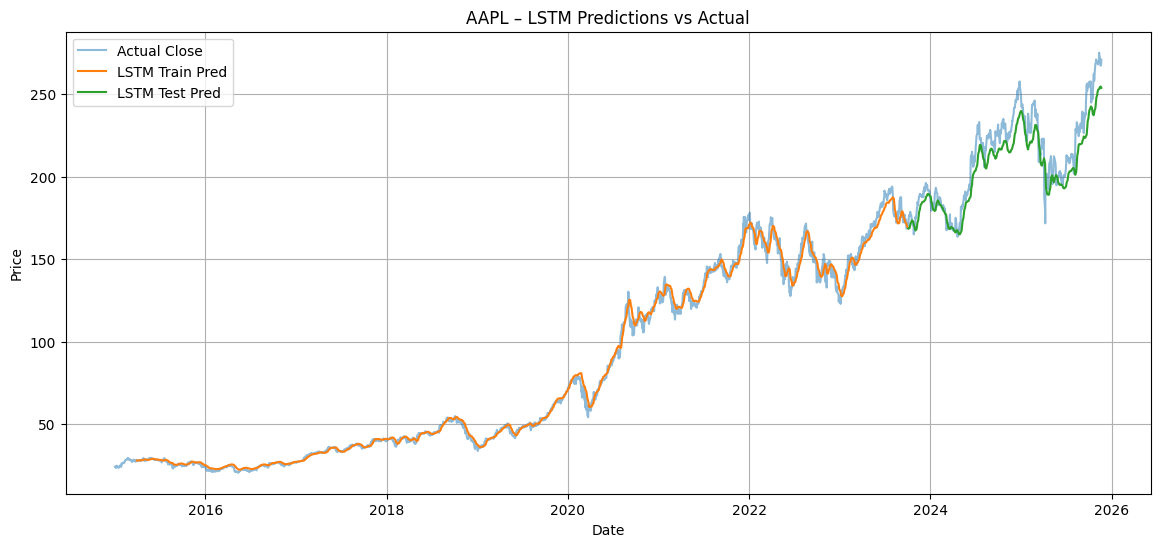

In [24]:
def build_lstm():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(LOOKBACK, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer=Adam(0.001), loss="mean_squared_error")
    return model

lstm_model = build_lstm()
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)

evaluate_and_plot(lstm_model, "LSTM")
?

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.0253 - val_loss: 0.0073
Epoch 2/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 3/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 9.8003e-04 - val_loss: 0.0015
Epoch 4/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 7.6381e-04 - val_loss: 0.0018
Epoch 5/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 7.4869e-04 - val_loss: 0.0012
Epoch 6/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 6.7259e-04 - val_loss: 0.0021
Epoch 7/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 5.4720e-04 - val_loss: 0.0032
Epoch 8/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 6.9257e-04 - val_loss: 0.0027
Epoch 9/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 5.0559e-04 - val_loss: 0.0022
Epoch 10/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 4.9403e-04 - val_loss: 8.6223e-04
Epoch 11/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 4.3778e-04 - val_loss: 7.8399e-04
Epoch 12/15
67/67 ━━━━━━━━━━

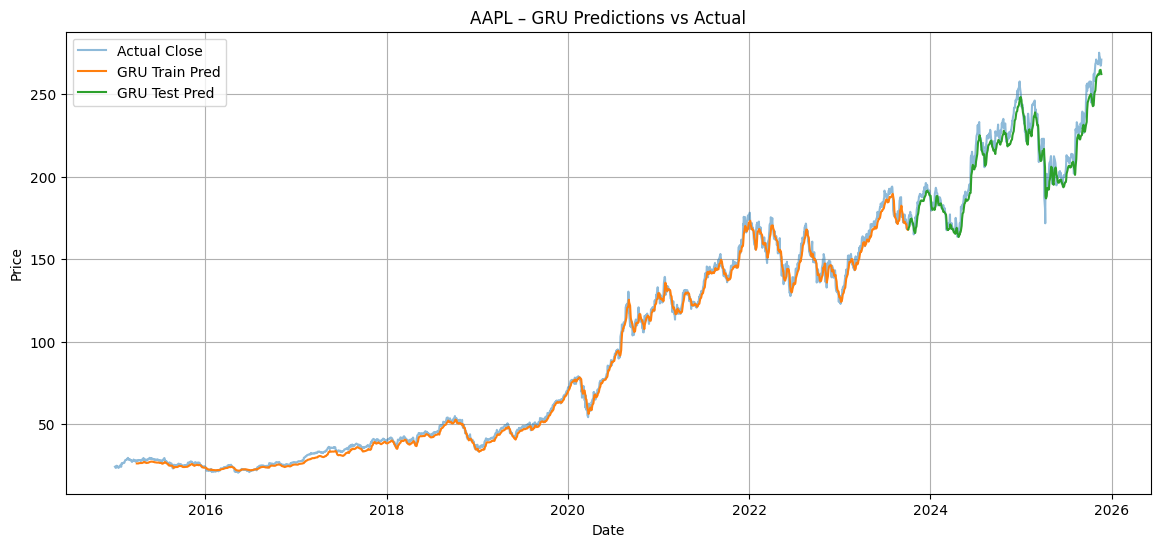

In [25]:
def build_gru():
    model = Sequential()
    model.add(GRU(64, return_sequences=True, input_shape=(LOOKBACK, 1)))
    model.add(Dropout(0.2))
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer=Adam(0.001), loss="mean_squared_error")
    return model

gru_model = build_gru()
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)

evaluate_and_plot(gru_model, "GRU")


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0070 - val_loss: 0.0032
Epoch 2/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.5790e-04 - val_loss: 0.0028
Epoch 3/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3068e-04 - val_loss: 0.0021
Epoch 4/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8758e-04 - val_loss: 0.0021
Epoch 5/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2954e-04 - val_loss: 0.0018
Epoch 6/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7274e-04 - val_loss: 0.0022
Epoch 7/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4385e-04 - val_loss: 0.0035
Epoch 8/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9907e-04 - val_loss: 0.0013
Epoch 9/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4730e-04 - val_loss: 0.0028
Epoch 10/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4592e-04 - val_loss: 0.0015
Epoch 11/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.3367e-04 - val_loss: 0.0014
Epoch 12/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 1

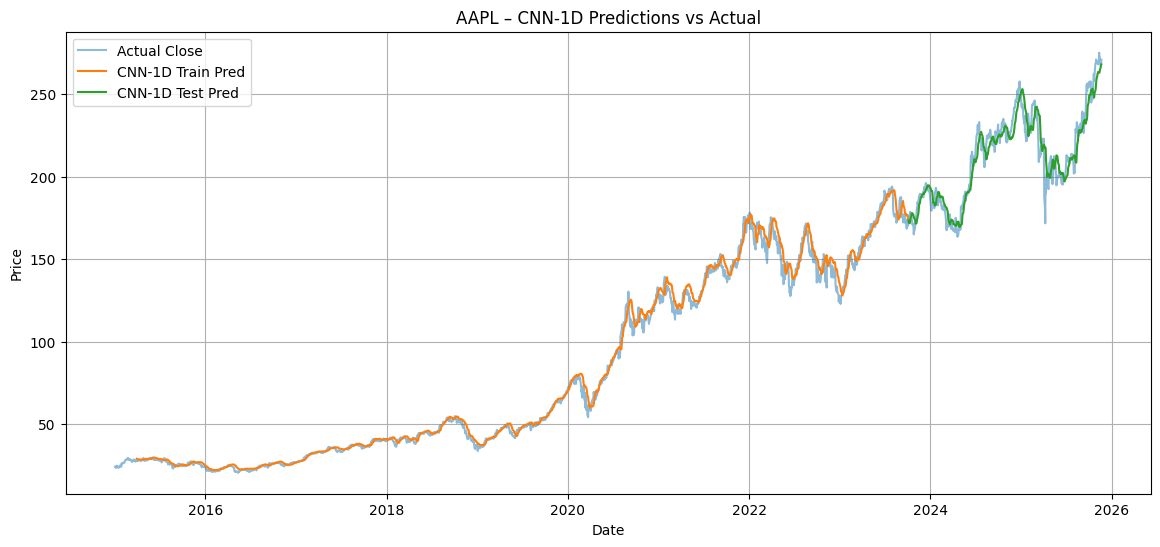

In [26]:
def build_cnn1d():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(LOOKBACK,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer=Adam(0.001), loss="mean_squared_error")
    return model

cnn_model = build_cnn1d()
cnn_history = cnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)

evaluate_and_plot(cnn_model, "CNN-1D")


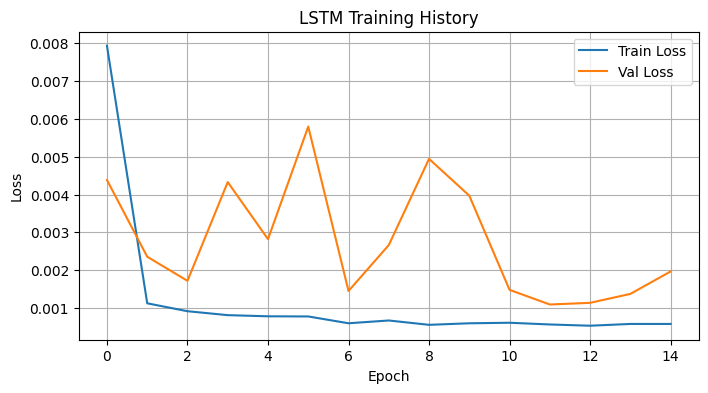

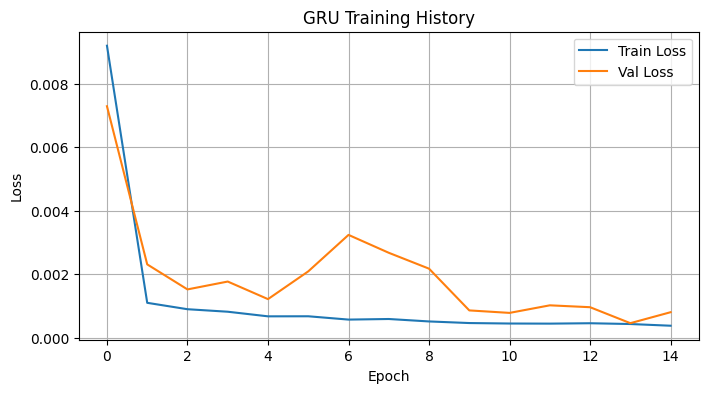

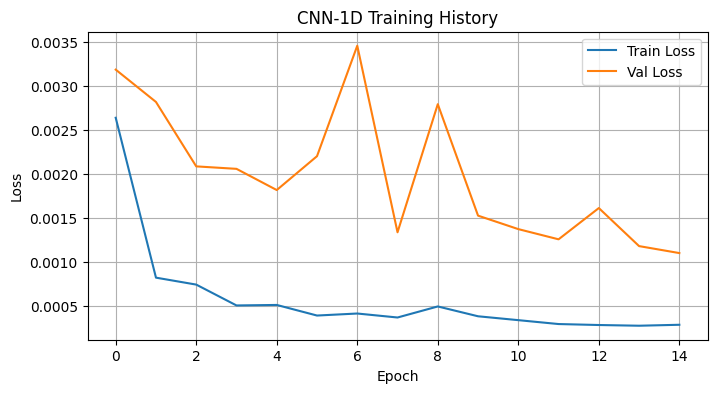

In [27]:
def plot_history(history, title):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(lstm_history, "LSTM Training History")
plot_history(gru_history,  "GRU Training History")
plot_history(cnn_history,  "CNN-1D Training History")


In [28]:
#RL
class TradingEnv:
    def __init__(self, prices, lookback):
        self.prices = prices.flatten()       # scaled prices
        self.lookback = lookback
        self.max_step = len(self.prices) - 1
        self.reset()

    def reset(self):
        self.step_idx = self.lookback
        self.position = 0  # -1 short, 0 flat, +1 long
        self.total_reward = 0.0
        return self._get_state()

    def _get_state(self):
        window = self.prices[self.step_idx - self.lookback:self.step_idx]
        # state = [window..., position]
        return np.append(window, self.position)

    def step(self, action):
        # Actions: 0 hold, 1 buy, 2 sell
        if action == 1:
            self.position = 1
        elif action == 2:
            self.position = -1
        # else: hold

        current_price = self.prices[self.step_idx]
        next_price    = self.prices[self.step_idx + 1] if self.step_idx + 1 <= self.max_step else current_price

        price_change  = next_price - current_price
        reward        = self.position * price_change
        self.total_reward += reward

        self.step_idx += 1
        done = self.step_idx >= self.max_step

        next_state = self._get_state()
        return next_state, reward, done


In [29]:
#DQN agent Keras
state_size = LOOKBACK + 1   # window + position
action_size = 3             # hold, buy, sell

def build_q_network():
    model = Sequential()
    model.add(Dense(64, input_dim=state_size, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(action_size, activation="linear"))
    model.compile(optimizer=Adam(0.001), loss="mse")
    return model

q_model = build_q_network()
target_model = build_q_network()
target_model.set_weights(q_model.get_weights())


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
#Replay buffer with helper
from collections import deque
import random

memory = deque(maxlen=5000)

def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

def act(state, epsilon):
    if np.random.rand() <= epsilon:
        return np.random.randint(action_size)
    q_values = q_model.predict(state[np.newaxis, :], verbose=0)[0]
    return np.argmax(q_values)

def replay(batch_size=32, gamma=0.99):
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    states, targets = [], []
    for state, action, reward, next_state, done in minibatch:
        target = q_model.predict(state[np.newaxis, :], verbose=0)[0]
        if done:
            target[action] = reward
        else:
            t = target_model.predict(next_state[np.newaxis, :], verbose=0)[0]
            target[action] = reward + gamma * np.max(t)
        states.append(state)
        targets.append(target)
    q_model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)


In [40]:
# Use only the last 300 points instead of full history
scaled_close_small = scaled_close[-300:]
env = TradingEnv(scaled_close_small, LOOKBACK)


In [41]:
EPISODES = 5              # start very small
EPSILON_START = 1.0
EPSILON_MIN = 0.05
EPSILON_DECAY = 0.95
BATCH_SIZE = 32
UPDATE_TARGET_EVERY = 5
TRAIN_EVERY = 10          # train every 10 steps
MAX_STEPS_PER_EPISODE = 500


Episode 1/5, steps=239, Total Reward (scaled): -0.10313, epsilon=0.950
Episode 2/5, steps=239, Total Reward (scaled): -0.30739, epsilon=0.902
Episode 3/5, steps=239, Total Reward (scaled): 0.42863, epsilon=0.857
Episode 4/5, steps=239, Total Reward (scaled): 0.01688, epsilon=0.815
Episode 5/5, steps=239, Total Reward (scaled): -0.17921, epsilon=0.774


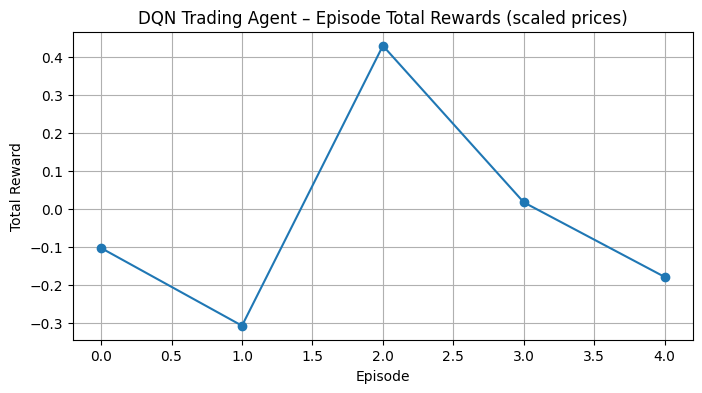

In [42]:
epsilon = EPSILON_START
episode_rewards = []

for e in range(EPISODES):
    state = env.reset()
    done = False
    step = 0

    while not done and step < MAX_STEPS_PER_EPISODE:
        action = act(state, epsilon)
        next_state, reward, done = env.step(action)
        remember(state, action, reward, next_state, done)
        state = next_state

        # Train less often and only when we have enough samples
        if len(memory) >= BATCH_SIZE and step % TRAIN_EVERY == 0:
            replay(BATCH_SIZE)

        step += 1

    # Epsilon decay
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY

    # Update target network
    if (e + 1) % UPDATE_TARGET_EVERY == 0:
        target_model.set_weights(q_model.get_weights())

    episode_rewards.append(env.total_reward)
    print(f"Episode {e+1}/{EPISODES}, steps={step}, Total Reward (scaled): {env.total_reward:.5f}, epsilon={epsilon:.3f}")

plt.figure(figsize=(8,4))
plt.plot(episode_rewards, marker='o')
plt.title("DQN Trading Agent – Episode Total Rewards (scaled prices)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


In [43]:
import joblib

# 1. Save model
lstm_model.save("lstm_model.h5")

# 2. Save scaler
joblib.dump(scaler, "scaler.pkl")

# 3. Save lookback
with open("lookback.txt", "w") as f:
    f.write(str(LOOKBACK))


In [50]:
mkdir stock-lstm-api


mkdir: cannot create directory ‘stock-lstm-api’: File exists


In [51]:
cd stock-lstm-api


/content/stock-lstm-api


In [53]:
!mv /content/lstm_model.h5 /content/stock-lstm-api/
!mv /content/scaler.pkl /content/stock-lstm-api/
!mv /content/lookback.txt /content/stock-lstm-api/


In [54]:
%%writefile app.py
import os
from datetime import datetime, timedelta

import numpy as np
import yfinance as yf
import joblib
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from tensorflow.keras.models import load_model

# ----- Load Model + Scaler -----
MODEL_PATH = "lstm_model.h5"
SCALER_PATH = "scaler.pkl"
LOOKBACK_PATH = "lookback.txt"

if not (os.path.exists(MODEL_PATH) and os.path.exists(SCALER_PATH) and os.path.exists(LOOKBACK_PATH)):
    raise RuntimeError("Files missing. Ensure model, scaler, and lookback.txt are in the same folder.")

model = load_model(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
with open(LOOKBACK_PATH, "r") as f:
    LOOKBACK = int(f.read().strip())

# ----- FastAPI App -----
app = FastAPI(title="Stock LSTM Predictor")

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

class PredictRequest(BaseModel):
    ticker: str
    days: int = 7

def download_close_prices(ticker: str, lookback: int):
    end = datetime.utcnow().date()
    start = end - timedelta(days=365 * 5)
    df = yf.download(ticker, start=start, end=end)
    if df.empty or "Close" not in df.columns:
        raise ValueError("Could not download data.")
    close = df["Close"].dropna().values.reshape(-1, 1)
    if len(close) < lookback:
        raise ValueError("Not enough data points.")
    return df.index, close

def make_future_predictions(close, days):
    scaled = scaler.transform(close)
    current = scaled[-LOOKBACK:].copy()
    preds_scaled = []

    for _ in range(days):
        inp = current.reshape(1, LOOKBACK, 1)
        next_scaled = model.predict(inp, verbose=0)[0, 0]
        preds_scaled.append(next_scaled)
        current = np.append(current[1:], [[next_scaled]], axis=0)

    preds_scaled = np.array(preds_scaled).reshape(-1, 1)
    preds = scaler.inverse_transform(preds_scaled)
    return preds.flatten()

@app.get("/")
def root():
    return {"message": "Stock LSTM API is running!"}

@app.post("/predict")
def predict(req: PredictRequest):
    try:
        dates, close = download_close_prices(req.ticker, LOOKBACK)
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

    future_prices = make_future_predictions(close, req.days)
    last_date = dates[-1]
    future_dates = [last_date + timedelta(days=i) for i in range(1, req.days+1)]

    return {
        "ticker": req.ticker.upper(),
        "predictions": [
            {"date": future_dates[i].strftime("%Y-%m-%d"), "price": float(future_prices[i])}
            for i in range(len(future_prices))
        ]
    }



Writing app.py


In [55]:
%%writefile requirements.txt
fastapi
uvicorn[standard]
tensorflow
pandas
numpy
yfinance
scikit-learn
joblib
python-multipart


Writing requirements.txt


In [58]:
!zip -r stock-lstm-api.zip .


  adding: lookback.txt (stored 0%)
  adding: app.py (deflated 56%)
  adding: scaler.pkl (deflated 39%)
  adding: lstm_model.h5 (deflated 11%)
  adding: requirements.txt (deflated 17%)
